# Machine learning to predict new crescent moon visibility

## Imports

In [204]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# MACHINE LEARNING IMPORTS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer

## Reading in data

In [205]:
METHOD = False # replace seen column with method seen column
RANDOM = False # replace data with random arrays
CLOUDCUT = False # cut all complete cloud cover data points
GRID_SEARCH = False # gridsearch for best random forest hyperparameters
REPEAT_ACCURACY = False #Run 20 times and calculate average accuracy

In [206]:
icouk_data_file = '..\\Data\\icouk_sighting_data_with_params.csv'
icop_data_file = '..\\Data\\icop_ahmed_2020_sighting_data_with_params.csv'
alrefay_data_file = '..\\Data\\alrefay_2018_sighting_data_with_params.csv'
allawi_data_file = '..\\Data\\schaefer_odeh_allawi_2022_sighting_data_with_params.csv'

icouk_data = pd.read_csv(icouk_data_file)
icop_data = pd.read_csv(icop_data_file)
alrefay_data = pd.read_csv(alrefay_data_file)
allawi_data = pd.read_csv(allawi_data_file)

data = pd.concat([icouk_data,icop_data,alrefay_data,allawi_data])



print(f"Loaded {data.shape[0]} rows")

data = data.drop(["Index","q","W","q'","W'"], axis = 1)

data = data.drop(['Date', 'Latitude', 'Longitude', 'Moon Age', 'Sunset', 'Moonset', 'Moon Az', 'Sun Az', 'Moon-Earth Dist', 'Sun-Moon Dist', 'DAZ', 'Parallax', 'Cloud Level'], axis = 1)

if METHOD: # method and methods columns, will be changed
    data = data.drop('Visibility', axis = 1)
    data = data.drop('Seen', axis = 1) # replaced by method column
    ptype = [r"Seen_eye", r"Seen_binoculars", r"Seen_telescope", r"Seen_ccd",r"Not_seen"] # CHANGE THIS
    
else:
    data = data[data["Method"] !="Seen_binoculars"] #DROP BINOCULARS
    data = data[data["Method"] !="Seen_ccd"] #DROP CCD
    data = data[data["Method"] !="Seen_telescope"] #DROP TELESCOPE
    
    data=data.drop(['Method','Methods','Visibility'], axis = 1)
    # List of label options

    ptype = [r"Seen", r"Not_seen"]

if RANDOM:
    data.insert(1,"Random1",np.random.rand(data.shape[0],1))
    data.insert(2,"Random2",np.random.rand(data.shape[0],1))
    data = data[['Seen', "Random1","Random2"]]

if CLOUDCUT:
    data = data[data["Cloud Level"] <= 0.5]

data.head(10)

Loaded 3626 rows


,Lag,Moon Alt,Sun Alt,ARCL,ARCV,Illumination,Seen
0,27.05935,1.51838,-1.73173,7.73820,3.25011,0.00455,Not_seen
1,57.80819,3.36486,-3.31808,10.99616,6.68294,0.00918,Not_seen
2,67.20869,3.82122,-3.52379,8.04228,7.34501,0.00492,Not_seen
3,94.68585,6.40548,-5.81151,14.37485,12.21699,0.01565,Not_seen
4,93.09817,6.46498,-5.86126,14.33820,12.32624,0.01557,Seen
5,51.24933,3.50315,-3.43885,8.71450,6.94200,0.00577,Not_seen
6,50.69011,3.53057,-3.46038,8.68183,6.99094,0.00573,Not_seen
7,50.38849,3.55198,-3.47683,8.67048,7.02881,0.00571,Not_seen
8,51.96781,3.43075,-3.37986,8.71957,6.81061,0.00578,Not_seen
9,95.45765,6.69411,-6.00369,18.77762,12.69780,0.02661,Not_seen


## Visualising variables

In [207]:
# Visualising a couple of variables.
variable_list =  data.columns.tolist()
print(variable_list)

# Plot data
showpairplot = False
if showpairplot == True:
   fig = sns.pairplot(data[variable_list], hue = 'Seen', palette = 'bright')

   # Change location of legend
   fig._legend.set_bbox_to_anchor((1.05, 0.5))

   # Add legend
   for t, l in zip(fig._legend.texts, ptype):
      t.set_text(str(t.get_text()) + " - " + str(l))

   plt.show()


['Lag', 'Moon Alt', 'Sun Alt', 'ARCL', 'ARCV', 'Illumination', 'Seen']


## ML Training

In [208]:
# List of features without label feature
variable_list =  data.columns.tolist()
features = variable_list


if METHOD:
    orig_y = np.array(data['Methods'].str.split(";"))
    mlb = MultiLabelBinarizer(classes=ptype)
    y = mlb.fit_transform(orig_y)
    features.remove('Method')
    features.remove('Methods')
    #pos = 'Seen_eye' # for ROC curve +ve result

    test = pd.DataFrame(y, columns=mlb.classes_)
    print(test.head(10))
else:
    y = np.array(data['Seen'])
    features.remove('Seen')
    pos = 'Seen' # for ROC curve +ve result

X = data[features]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80/20 training/test split

In [209]:
# Produce randomforest classifier model and fit to training data
# Keep the random_state=1 in your arguments
# gini or entropy
if METHOD:
    rf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100,n_jobs=-1))#, criterion = 'gini', max_depth=12,random_state=0, oob_score=True)
else:
    rf = RandomForestClassifier(n_estimators=100,n_jobs=-1)
# Fitting takes the input and "truth" data for classification purposes
rf.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [210]:
def get_easiest_method_array(methods):
    easiest_methods = np.zeros(methods.shape)
    easiest_methods[np.arange(0,methods.shape[0],1),np.argmax(methods,axis=1)] = 1
    return easiest_methods

def get_easiest_method_names(methods):
    easiest_methods = get_easiest_method_array(methods)
    return mlb.inverse_transform(easiest_methods.astype(int))

# Produce predictions for the classification of your training dataset using your model:
y_pred = rf.predict(x_train)

# plot the accuracies of said predictions
print("Accuracy on training dataset:",accuracy_score(y_train, y_pred))
rf_acc_train = accuracy_score(y_train, y_pred)
y_pred = rf.predict(x_test)

print("Accuracy on testing dataset:", accuracy_score(y_test, y_pred))
rf_acc_test = accuracy_score(y_test, y_pred)

if METHOD:
    print("Accuracy on testing dataset (easiest method only):", accuracy_score(get_easiest_method_names(y_test), get_easiest_method_names(y_pred)))



Accuracy on training dataset: 0.9995954692556634
Accuracy on testing dataset: 0.8966074313408724


## ROC curve

In [211]:
# Get predicted class probabilities for the test set 
if METHOD:
    #y_pred_prob = rf.predict_proba(x_test)
    #roc_auc = roc_auc_score(y_test, y_pred_prob)
    print("Not currently working")
else:
    y_pred_prob = rf.predict_proba(x_test)[:, 1] 
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Compute the ROC AUC score 
    roc_auc

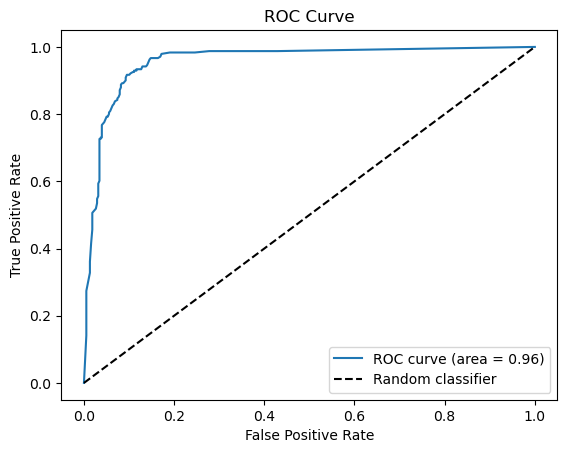

In [212]:
if METHOD:
    # roc curve for Multi classes 
    colors = ['orange','red','green','blue','purple'] 
    #for i in range(len(ptype)):     
    #    fpr, tpr, thresh = roc_curve(y_test, y_pred_prob[:,i], pos_label=ptype[i]) 
    #    plt.plot(fpr, tpr, linestyle='--',color=colors[i], label=ptype[i]+' vs Rest') 
    # roc curve for tpr = fpr  
    #plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
    #plt.title('Multiclass ROC curve') 
    #plt.xlabel('False Positive Rate') 
    #plt.ylabel('True Positive rate') 
    #plt.legend() 
    #plt.show()
    print("Not currently working")
else:
    # Compute the false positive rate (FPR) 
    # and true positive rate (TPR) for different classification thresholds 
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=pos)
    # Plot the ROC curve 
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) 
    # roc curve for tpr = fpr  
    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('ROC Curve') 
    plt.legend(loc="lower right") 
    plt.show()

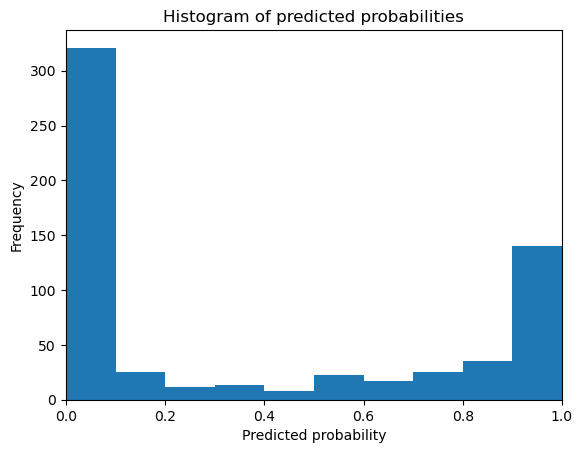

In [213]:
# Plot the predicted class probabilities 
if not METHOD:
    plt.hist(y_pred_prob, bins=10) 
    plt.xlim(0, 1) 
    plt.title('Histogram of predicted probabilities') 
    plt.xlabel('Predicted probability') 
    plt.ylabel('Frequency') 
    plt.show() 

In [214]:
# Function to run thr random forest several times to get an average
def random_forest(x_train, y_train, x_test, y_test, rf):
    accuracy_arr = []
    for i in range(20):
        # Fitting takes the input and "truth" data for classification purposes
        rf.fit(x_train, y_train)
        # Produce predictions for the classification of your training dataset using your model:
        y_pred = rf.predict(x_test)
        #print("Accuracy on testing dataset:",accuracy_score(y_test, y_pred))
        accuracy_arr.append(accuracy_score(y_test, y_pred))
    
    accuracy_avg = np.mean(accuracy_arr)
    accuracy_std = np.std(accuracy_arr)
    return accuracy_avg,accuracy_std

In [215]:
if REPEAT_ACCURACY:
    rf = RandomForestClassifier(n_estimators=100, criterion='gini')#, criterion = 'gini', max_depth=12,random_state=0, oob_score=True)
    accuracy_val=random_forest(x_train, y_train, x_test, y_test, rf)

    print(r"When run 20 times the accuracy is {:.5} \pm {:.5}:".format(accuracy_val[0],accuracy_val[1]))

In [216]:
print('Oob Score: ', rf.score(x_test, y_test))

Oob Score:  0.8966074313408724


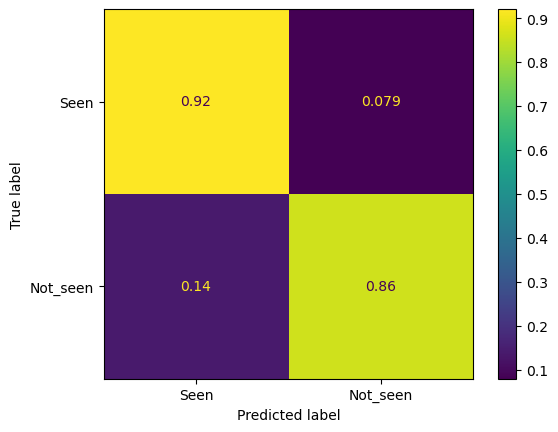

In [217]:
# plot your confusion matrix
if METHOD:
    cm = confusion_matrix(get_easiest_method_names(y_test), get_easiest_method_names(y_pred),normalize = 'true')
else:
    cm = confusion_matrix(y_test, y_pred,normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ptype)
disp.plot()
plt.show()


In [218]:
def plot_sightings(sights):
    sightings = pd.DataFrame(get_easiest_method_names(sights),columns =["Method"])
    pies = sightings["Method"].value_counts(sort=False)
    labels = sightings["Method"].unique()
    plt.pie(pies, labels=labels, autopct='%1.0f%%')
    plt.title('Distribution of sightings')
    plt.show()

if METHOD:
    plot_sightings(y_pred)
    plot_sightings(y_test)

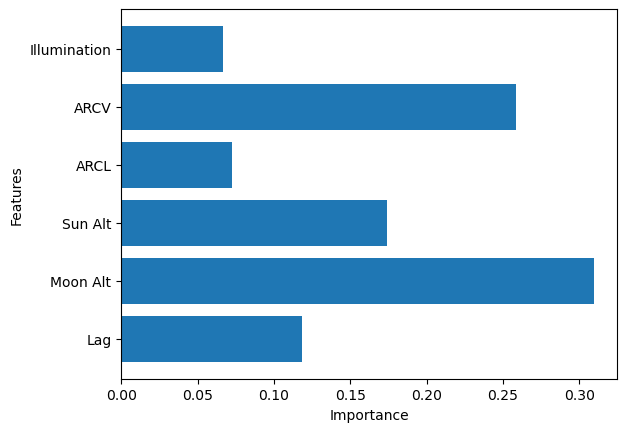

In [219]:
# Plot importance
if METHOD:
    feat_impts = [] 
    for clf in rf.estimators_:
        feat_impts.append(clf.feature_importances_) 

    importance = np.mean(feat_impts, axis=0)

else:
    importance = rf.feature_importances_

ytix = features
plt.barh(range(len(features)), importance)
plt.yticks(range(len(features)), features)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

Hyperparameter adjustment - not of much note yet

In [220]:
if GRID_SEARCH:
    rf = RandomForestClassifier(random_state=42)

    params = {
        'max_depth': [2,3,5,10,20],
        'min_samples_leaf': [5,10,20,50,100,200],
        'n_estimators': [10,25,30,50,100,200]
    }

    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator=rf,
        param_grid=params,
        cv = 4,
         verbose=1, scoring="accuracy")

    grid_search.fit(x_train, y_train)
    grid_search.best_score_
    rf_best = grid_search.best_estimator_
    rf_best

    # Produce predictions for the classification of your training dataset using your model:
    y_pred_best = rf_best.predict(x_train)

    # plot the accuracies of said predictions
    print("Accuracy on training dataset:",accuracy_score(y_train, y_pred_best))
    rf_best_acc_train = accuracy_score(y_train, y_pred_best)
    y_pred_best = rf_best.predict(x_test)
    print("Accuracy on testing dataset:",accuracy_score(y_test, y_pred_best))
    rf_best_acc_train = accuracy_score(y_test, y_pred_best)

In [221]:
#rf_best

In [222]:
#rf_best = grid_search.best_estimator_
#rf_best

In [223]:
# Produce predictions for the classification of your training dataset using your model:
#y_pred_best = rf_best.predict(x_train)

# plot the accuracies of said predictions
#print("Accuracy on training dataset:",accuracy_score(y_train, y_pred_best))
#rf_best_acc_train = accuracy_score(y_train, y_pred_best)
#y_pred_best = rf_best.predict(x_test)
#print("Accuracy on testing dataset:",accuracy_score(y_test, y_pred_best))
#rf_best_acc_train = accuracy_score(y_test, y_pred_best)